# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= True
inspectRate= False

Import libraries

In [3]:
# import resource

# # Convert 4GB to bytes
# memory_limit = 62 * 1024 * 1024 * 1024

# # Set the memory limit
# resource.setrlimit(resource.RLIMIT_DATA, (memory_limit, memory_limit))


In [4]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [5]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/14rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/15rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/16rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/14rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/15rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/16rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [6]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [7]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [8]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [9]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [10]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.323270        0.200792  0.050435  0.298915  0.017996   
       0.25   0.304545        0.196101  0.051583  0.259418  0.068024   
       0.50   0.293490        0.197943  0.064479  0.234536  0.096649   
       0.75   0.293760        0.181472  0.073389  0.189746  0.117242   
       1.00   0.312714        0.172955  0.076043  0.174303  0.145953   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201447  0.009249  0.040422  0.048604  0.000000  
       0.25  0.206267  0.010299  0.041466  0.048932  0.000521  
       0.50  0.190710  0.009649  0.040983  0.049320  0.001492  
       0.75  0.200268  0.007965  0.034687  0.048115  0.002483  
       1.00  0.200571  0.007439  0.039626  0.049723  0.003489

In [11]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.295315        0.203393  0.049610  0.292473  0.020236   
       0.25   0.304325        0.199437  0.056394  0.256506  0.066704   
       0.50   0.310393        0.180669  0.061755  0.207765  0.101113   
       0.75   0.286473        0.169643  0.063834  0.182014  0.121428   
       1.00   0.327291        0.167648  0.080639  0.177326  0.132740   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.182364  0.009452  0.037824  0.049237  0.000000  
       0.25  0.206057  0.009817  0.043107  0.051208  0.000576  
       0.50  0.181917  0.008689  0.042067  0.052952  0.001588  
       0.75  0.196835  0.008096  0.037195  0.047392  0.002817  
       1.00  0.218232  0.006660  0.036462  0.048643  0.004028

In [12]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.301919        0.184715  0.048514  0.300995  0.018765   
       0.25   0.295775        0.200791  0.052227  0.238590  0.067467   
       0.50   0.308329        0.189150  0.062230  0.238051  0.102937   
       0.75   0.292882        0.160581  0.073207  0.209592  0.123956   
       1.00   0.307566        0.169026  0.070934  0.188766  0.138183   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.193786  0.009556  0.040998  0.048033  0.000000  
       0.25  0.218912  0.009763  0.037017  0.046846  0.000649  
       0.50  0.207158  0.009325  0.038161  0.049611  0.001467  
       0.75  0.207389  0.008191  0.036073  0.046433  0.002465  
       1.00  0.219518  0.007512  0.035744  0.050760  0.003692

# Average of replicate values

Metabolites

In [13]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25   0.297295        0.197849  0.055988  0.250469  0.068398   
         0.50   0.292495        0.187801  0.069633  0.225384  0.101600   
         0.75   0.272125        0.168785  0.081125  0.192689  0.122388   
         1.00   0.286510        0.167587  0.089382  0.180670  0.140800   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.192532  0.009419  0.039748  0.048625  0.000000  
         0.25  0.210409  0.009964  0.040530  0.049189  0.000383  
         0.50  0.193251  0.009243  0.040402  0.051150  0.001001  
         0.75  0.201464  0.008145  0.035976  0.048149  0.001716  
         1.00  0.212690  0.007334  0.037243  0.050990  0.002488

Enzymes

In [14]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         0.25  4.623589e+06  2.294647e+06  219616.822399  1.384614e+06   
         0.50  5.413871e+06  3.522874e+06  331075.210595  2.208463e+06   
         0.75  6.027501e+06  4.276124e+06  425326.578119  2.527476e+06   
         1.00  6.063303e+06  4.350573e+06  454508.664109  3.138185e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      25.267722  5.244708e+01  5.224924e+01      18.570128   
         0.25  473817.229448  2.259331e+06  2.735048e+06  431494.198134   
         0.50  741116.993421  3.872225e+06  3.293242e+06  616722.782670   
         0.75  817806.196468  4.862051e+06  3.478237e+06  770881.423191   
         1.00  978987.234359  5.304373e+06  3.736293e+06  833744.174216   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.506563  
         0.25     186542.284533  
         0.50     286414.752383  
         0.75     351941.057897  
         1.00     411111.976360

In [15]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [16]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [17]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

# Impute missing data

In [18]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [19]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [20]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

In [22]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [23]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [24]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,5,2)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

In [25]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [26]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         0.25   4.623589e+06  2.294647e+06  2.196168e+05  1.384614e+06   
         0.50   5.413871e+06  3.522874e+06  3.310752e+05  2.208463e+06   
         0.75   6.027501e+06  4.276124e+06  4.253266e+05  2.527476e+06   
         1.00   6.063303e+06  4.350573e+06  4.545087e+05  3.138185e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.806058e+06  2.716837e+06  1.734610e+06  1.964429e+06   
         23.25  2.749613e+06  2.649696e+06  1.714084e+06  2.107597e+06   
         23.50  2.825958e+06  2.669877e+06  1.786594e+06  2.013892e+06   
         23.75  2.688194e+06  2.539673e+06  1.781730e+06  1.923510e+06   
         24.00  2.639673e+06  2.764951e+06  1.738019e+06  2.047623e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         0.25   4.738172e+05  2.259331e+06  2.735048e+06  4.314942e+05   
         0.50   7.411170e+05  3.872225e+06  3.293242e+06  6.167228e+05   
         0.75   8.178062e+05  4.862051e+06  3.478237e+06  7.708814e+05   
         1.00   9.789872e+05  5.304373e+06  3.736293e+06  8.337442e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.469618e+06  4.061957e+06  4.347534e+06  1.241550e+06   
         23.25  1.450050e+06  3.943583e+06  4.490479e+06  1.240515e+06   
         23.50  1.585924e+06  3.959418e+06  4.406181e+06  1.200499e+06   
         23.75  1.532031e+06  3.876796e+06  4.207651e+06  1.300224e+06   
         24.00  1.431555e+06  4.049351e+06  4.386481e+06  1.244816e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.950656e+01   0.306835        0.196300  0.049520   
         0.25       1.865423e+05   0.297295        0.197849  0.055988   
         0.50       2.864148e+05   0.292495        0.187801  0.069633   
         0.75       3.519411e+05   0.272125        0.168785  0.081125   
         1.00       4.111120e+05   0.286510        0.167587  0.089382   
...                          ...        ...             ...       ...   
WT       23.00      1.461482e+06   0.781785        0.014512  0.019834   
         23.25      1.515575e+06   0.736414        0.014641  0.019183   
         23.50      1.446927e+06   0.755956        0.014301  0.020733   
         23.75      1.460263e+06   0.756040        0.014851  0.021714   
         24.00      1.483635e+06   0.828982        0.014775  0.022484   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         0.25   0.250469  0.068398  0.210409  0.009964  0.040530  0.049189   
         0.50   0.225384  0.101600  0.193251  0.009243  0.040402  0.051150   
         0.75   0.192689  0.122388  0.201464  0.008145  0.035976  0.048149   
         1.00   0.180670  0.140800  0.212690  0.007334  0.037243  0.050990   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.116885  0.097919  0.301282  0.013141  0.026095  0.097143   
         23.25  0.113084  0.097356  0.306234  0.013655  0.023374  0.101186   
         23.50  0.115384  0.098481  0.302331  0.013217  0.022635 

rate of reaction

In [27]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.063218       -0.018066  0.040316 -0.187786  0.204053   
         0.25    -0.044773       -0.026331  0.041130 -0.152165  0.161545   
         0.50    -0.026328       -0.034596  0.041945 -0.116545  0.119037   
         0.75    -0.014672       -0.031585  0.043041 -0.077583  0.079276   
         1.00    -0.016664       -0.032512  0.026032 -0.049588  0.059743   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.024849        0.000823  0.001125 -0.000379 -0.000179   
         23.25   -0.028841        0.001194  0.001965  0.003149  0.000531   
         23.50    0.045608        0.000295  0.003132  0.002674  0.001919   
         23.75    0.169703        0.000567  0.004431  0.011381  0.003753   
         24.00    0.293799        0.000840  0.005731  0.020089  0.005587   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001246  0.001136 -0.000023  0.001942  0.001526  
         0.25   0.005651 -0.000630 -0.001924  0.001709  0.002025  
         0.50   0.012548 -0.002396 -0.003826  0.001476  0.002523  
         0.75   0.008458 -0.003624 -0.004865  0.000184  0.003040  
         1.00   0.018771 -0.003947 -0.004751  0.002370  0.003185  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002996  0.000274 -0.002350 -0.008681  0.014326  
         23.25  0.024923 -0.000133 -0.000987 -0.007820  0.007468  
         23.50  0.005967 -0.000329 -0.001157  0.002498  0.019237  
         23.75 -0.008848 -0.000445  0.003163  0.004658  0.016197  
         24.00 -0.023663 -0.000562  0.007483  0.006818  0.013157  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [28]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [29]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [30]:
# problemInstance = MyProblem()
# problemInstance._derivatives_error_fcn_gen(X,y)

# kr = [1e+01, 10**8.5,10**8.5, # AtoB
#       1e+02, 10**9, 10**9, 10**9, # HMGS
#       1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
#       1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
#       1e+02, 1e+08, # PMK
#       1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
#       1e+01, 1e+07, # IDI 
#       1e+03, 1e+06, 1e+08, 1e+08, # GPPS
#       1e+01, 1e+08, # LS
#       0.05,10**0.1] # Vin set to 0.05, ks3
# import numpy as np
# logkr=np.log10(kr)

# OUT = {}
# problemInstance._evaluate(logkr,OUT)
# OUT["F"]

In [31]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 8
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [32]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')

from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)#1e4

## New Functions defined for the loop

In [33]:
def computeR2(estimatedKrList,actualKrList):    
    ''' 
    R2 of fitting actualKr =  estimatedKr
    '''
    # mean of all actual parameter values
    actualKr_mean = np.mean(actualKrList)
    
    RSS = 0 # initiate residual sum of square
    TSS = 0 # intiate total sum of square
    for y,y_hat in zip(actualKrList,estimatedKrList):
        #print( str(y) + ': ' + str (y_hat) ) 
        RSS = RSS + (y - y_hat)**2
        TSS = TSS + (y - actualKr_mean)**2
        
    R2 = 1 -(RSS/TSS)
    if R2 > 0:
        R = R2**(0.5)
    else:
        R=float("NaN")
    neglog = -math.log(1-R2,10)
    
    print ('R2: ' +str(R2) )
    print ('R: ' + str(R) )
    print ('-log10(1-R2): ' + str(neglog) )
    
    return R2, R, neglog

def plot_neglog(R_list, title):
    plt.plot(R_list)
    plt.xlabel('No. of seeds ')
    plt.ylabel('Metric')
    plt.title(title +' metric vs. no. of seeds: ' + str(len(R_list)))

    # Save the plot as a PDF file, create a folder called whatever the title is before running 
    plt.savefig(title + '/seednumber_' + str(len(R_list)) +'_R_check.pdf',transparent=False)
    
    # Show the plot (optional)
    plt.show()


In [34]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [35]:
problemInstance = MyProblem()
problemInstance._derivatives_error_fcn_gen(X,y)

# krALL = [1e+01, 10**8.5,10**8.5, # AtoB
#       1e+02, 10**9, 10**9, 10**9, # HMGS
#       1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
#       1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
#       1e+02, 1e+08, # PMK
#       1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
#       1e+01, 1e+07, # IDI 
#       1e+03, 1e+06, 1e+08, 1e+08, # GPPS
#       1e+01, 1e+08, # LS
#       0.05,10**0.1] # Vin set to 0.05, ks3
# import numpy as np
# logkrALL=np.log10(krALL)

# OUT = {}
# problemInstance._evaluate(logkrALL,OUT)
# kkk=OUT["F"]
# kk=kkk[0]
# kk

<function __main__.MyProblem._derivatives_error_fcn_gen.<locals>._derivatives_error_fcn(free_params)>

## Run optimization using different initial seed solutions & evaluate quality of their mean/median

Algorithm in use: SRES

Time required: 49182.35460352898
Best solution found: 
X = [-9.72822377e+00  1.19940696e+00  1.77573946e-01 -4.16154424e+00
  4.86762767e-01  1.05730951e-07  4.59546324e-01 -4.21917929e+00
  2.72719458e-01  4.12697416e+00  3.00656014e+00  3.18311464e+00
  4.37634975e-01  3.63344585e-02  2.97810757e+00  1.63501671e-02
  4.62326502e-01 -1.13757611e+01  1.78284433e+00  1.50344218e+00
 -9.57595028e+00  9.74578233e-01  3.30045804e+00  8.11279857e-02
  3.18978103e+00  2.38670576e+00  9.92677658e-01  5.85015941e+00
 -9.23804767e+00  2.54399958e+00  1.60937951e+00  3.26391124e+00
 -4.34940060e+00  5.51912517e-01  9.89107780e-01 -1.30102997e+00]
F = [19.32199705]
CV = [0.]
R2: 0.8948855738165881
R: 0.9459839183710197
-log10(1-R2): 0.9783376761515494
Mean solution thus far: 
 [-9.72822377401768, 1.1994069619547718, 0.177573946314735, -4.161544244313436, 0.48676276665325297, 1.0573095085223767e-07, 0.45954632412322516, -4.219179290561144, 0.27271945804596687, 4.12697415970

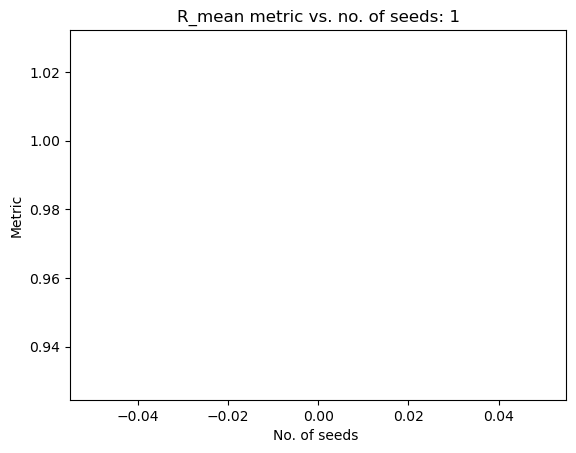

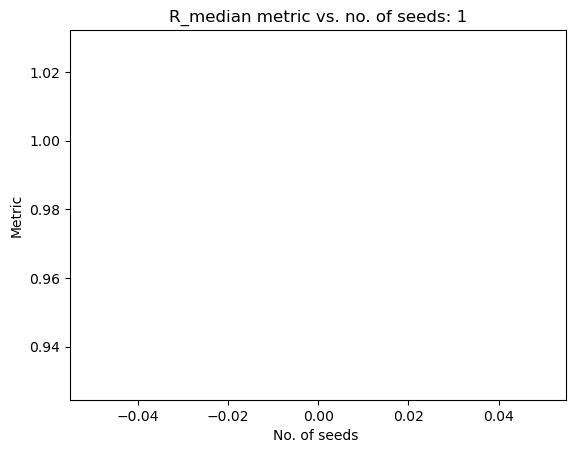

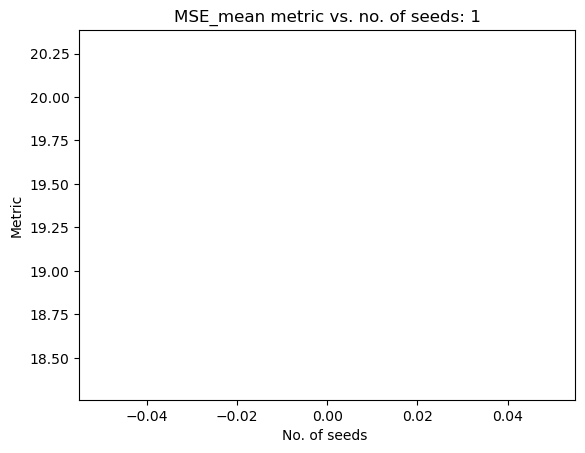

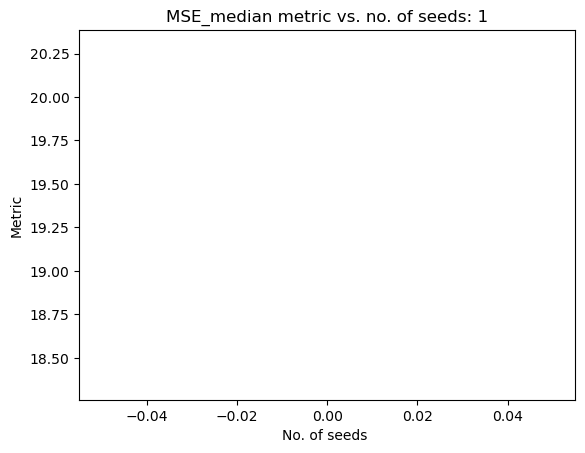

Time required: 49217.03219771385
Best solution found: 
X = [-9.15411817e+00  1.10730085e+00  9.48164851e-02 -4.15030256e+00
  4.84922355e-01  1.73765707e-07  4.58431470e-01 -4.39560254e+00
  2.96139916e-01  4.21123000e+00  3.06950442e+00  3.23980942e+00
  4.22263892e-01  3.55321422e-02  2.94910392e+00  1.65789148e-02
  4.63973685e-01 -1.10415383e+01  1.72328043e+00  1.45106307e+00
 -9.18375705e+00  9.27465605e-01  3.16496390e+00  8.82938506e-02
  3.04184877e+00  2.29230096e+00  9.08142069e-01  5.49156834e+00
 -7.98481742e+00  2.22598422e+00  1.56977975e+00  2.86894788e+00
 -4.44437469e+00  5.68612159e-01  9.88496672e-01 -1.30103000e+00]
F = [19.31822266]
CV = [0.]
R2: 0.8767742470821149
R: 0.9363622413799666
-log10(1-R2): 0.9092985195957672
Mean solution thus far: 
 [-9.441170970933292, 1.1533539081915467, 0.13619521568713963, -4.155923402816499, 0.4858425609773136, 1.3974832885743008e-07, 0.4589888970214431, -4.307390914547337, 0.2844296868733239, 4.169102080381723, 3.038032282345117,

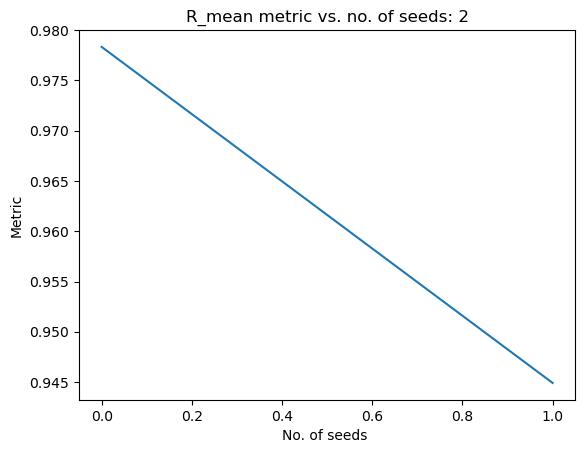

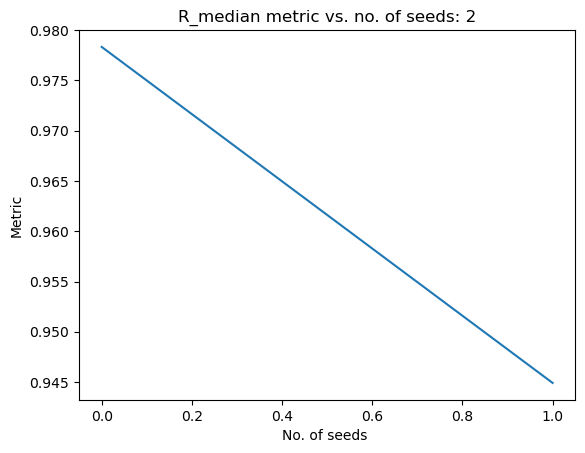

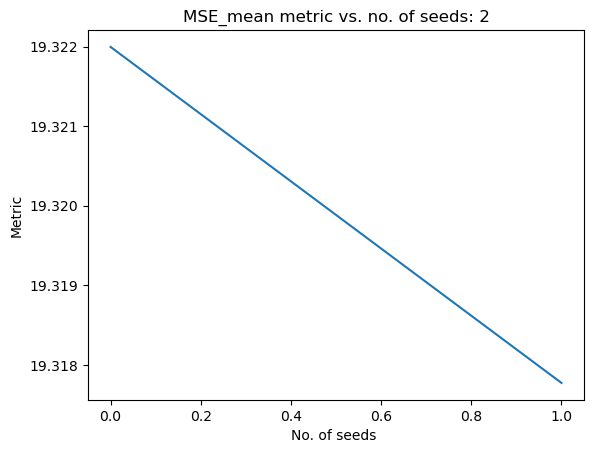

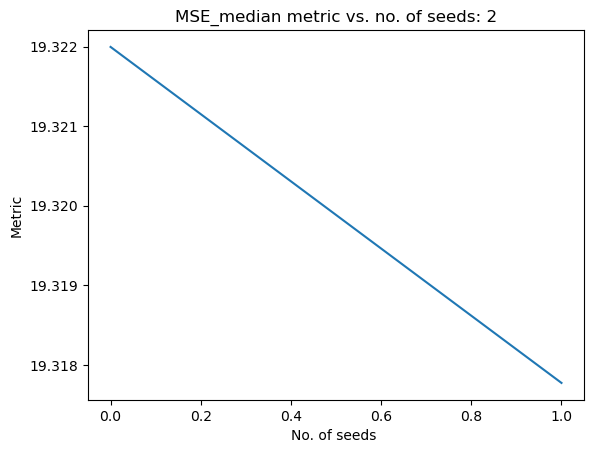

Time required: 49917.19879078865
Best solution found: 
X = [-9.67289820e+00  1.19065305e+00  1.71094503e-01 -4.15973544e+00
  4.86361880e-01  7.87573420e-07  4.59550095e-01 -4.50821203e+00
  3.09614347e-01  4.28746263e+00  3.12500528e+00  3.29372028e+00
  4.39369871e-01  3.63157259e-02  2.98387236e+00  1.88486777e-02
  4.59423659e-01 -1.14179658e+01  1.79034524e+00  1.51026493e+00
 -9.60164954e+00  9.76567439e-01  3.29924318e+00  8.08856947e-02
  3.20187539e+00  2.32677752e+00  9.29839928e-01  5.59298988e+00
 -9.36864752e+00  2.57567854e+00  1.60871580e+00  3.30529042e+00
 -4.36324935e+00  5.54513223e-01  9.91701219e-01 -1.30102993e+00]
F = [19.32303095]
CV = [0.]
R2: 0.896121862441661
R: 0.9466371334580431
-log10(1-R2): 0.9834758454827345
Mean solution thus far: 
 [-9.518413380367095, 1.1657869564345802, 0.14782831162033014, -4.157194081307309, 0.4860156674383865, 3.556900258003264e-07, 0.4591759631172982, -4.374331287047956, 0.2928245736933197, 4.208555596478271, 3.0670232807749556, 

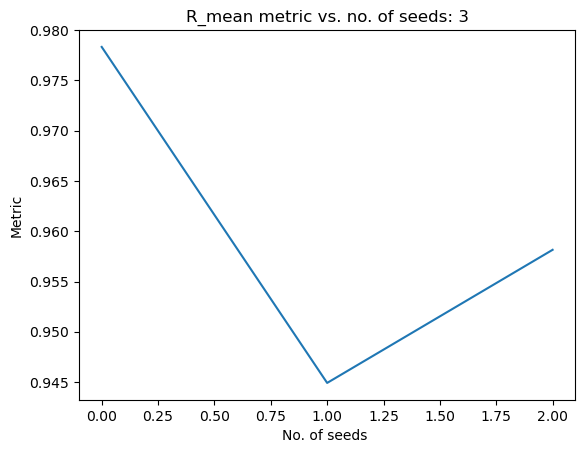

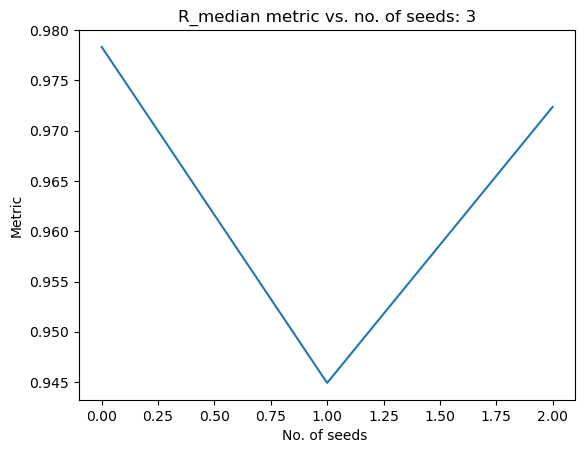

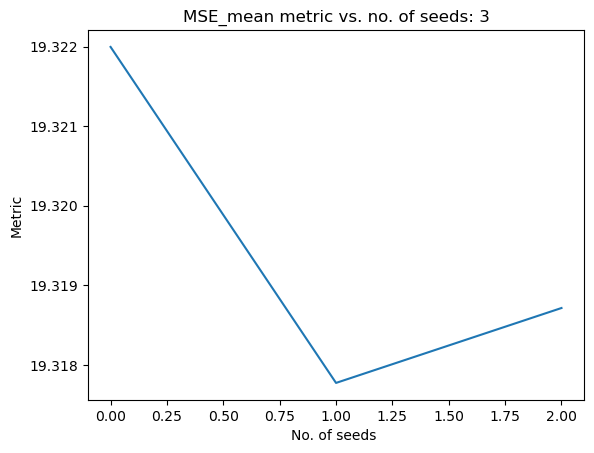

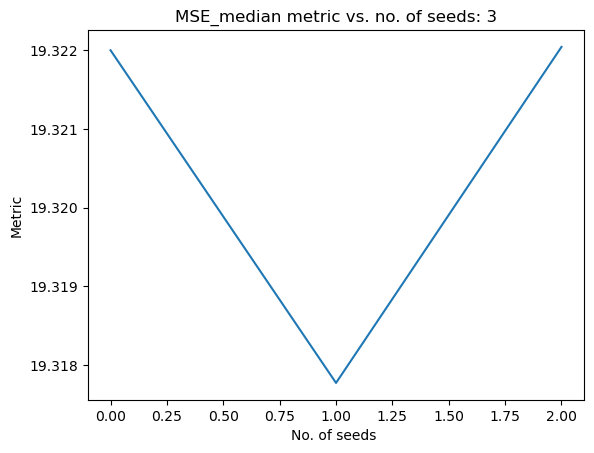

Time required: 49643.820222616196
Best solution found: 
X = [-9.26590408e+00  1.12517178e+00  1.10203882e-01 -4.16006747e+00
  4.86314004e-01  6.12462736e-06  4.59543502e-01 -4.60152828e+00
  3.21026911e-01  4.34767282e+00  3.16972255e+00  3.33645848e+00
  4.49588453e-01  3.67003024e-02  3.00169983e+00  2.00463593e-02
  4.54922816e-01 -1.16072153e+01  1.82403927e+00  1.53952917e+00
 -9.78369803e+00  9.99670460e-01  3.36690351e+00  8.10746526e-02
  3.25923736e+00  2.45778113e+00  9.97938776e-01  5.91077869e+00
 -9.77175845e+00  2.68341317e+00  1.63905519e+00  3.43384706e+00
 -4.43594578e+00  5.67964364e-01  1.00462475e+00 -1.30102997e+00]
F = [19.3294353]
CV = [0.]
R2: 0.903214660945246
R: 0.9503760629062824
-log10(1-R2): 1.0141904241982338
Mean solution thus far: 
 [-9.455286054106944, 1.1556331621620262, 0.1384222041004435, -4.157912428355191, 0.4860902516532689, 1.7979243588620786e-06, 0.45926784790527553, -4.431130534049, 0.2998751579780526, 4.243334902837352, 3.092698097377222, 3.2

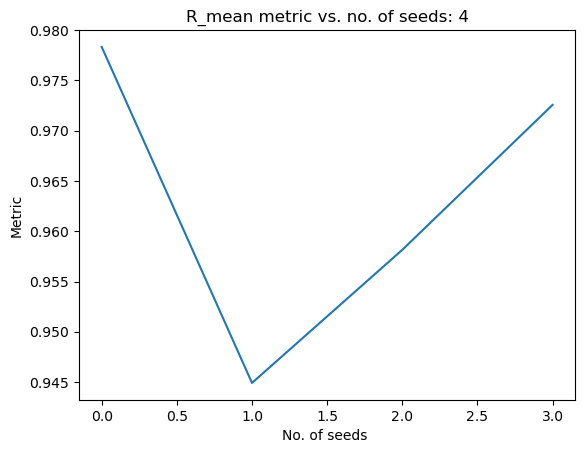

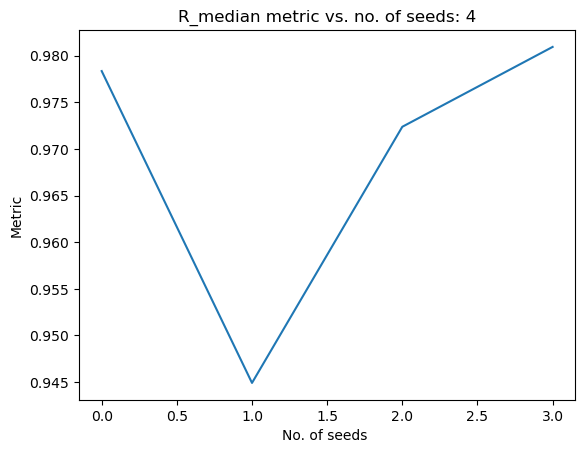

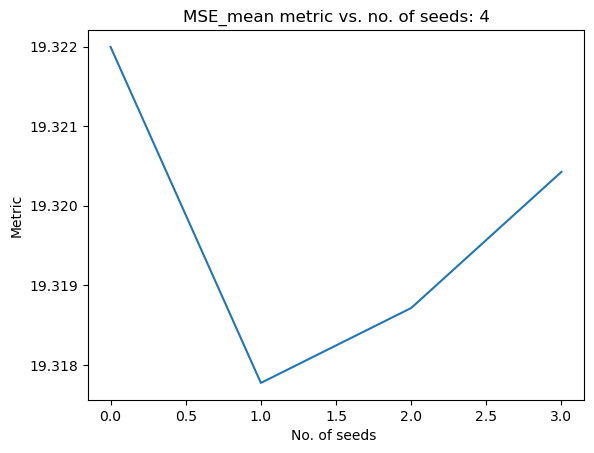

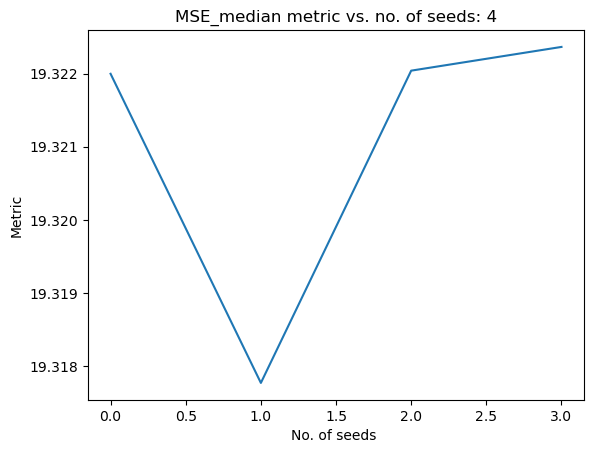

Time required: 49441.55429029465
Best solution found: 
X = [-9.60901349e+00  1.18033512e+00  1.61109089e-01 -4.15097966e+00
  4.85001121e-01  6.36057198e-09  4.58377537e-01 -4.39593712e+00
  2.95952298e-01  4.21540332e+00  3.07378389e+00  3.24395536e+00
  4.27070906e-01  3.56503051e-02  2.95466208e+00  1.66229235e-02
  4.60977355e-01 -1.11155362e+01  1.73651344e+00  1.46195317e+00
 -9.18091727e+00  9.27728829e-01  3.16880756e+00  8.85392042e-02
  3.03745266e+00  2.28898817e+00  9.14653625e-01  5.51346580e+00
 -8.05424588e+00  2.24378345e+00  1.57260881e+00  2.89097066e+00
 -4.42457664e+00  5.65063760e-01  9.87270941e-01 -1.30102985e+00]
F = [19.3180534]
CV = [0.]
R2: 0.8803229245512804
R: 0.9382552555415186
-log10(1-R2): 0.9219890322135869
Mean solution thus far: 
 [-9.48603154209755, 1.1605735546046998, 0.14295958112685256, -4.156525875176716, 0.48587242544485204, 1.4396116014860305e-06, 0.45908978579713333, -4.424091851858449, 0.29909058598967886, 4.23774858597635, 3.0889152555950647

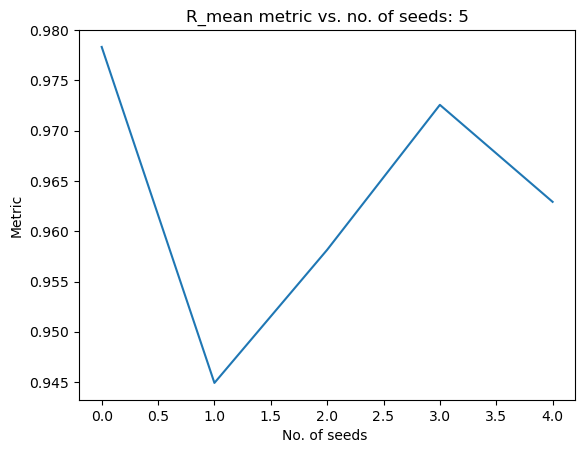

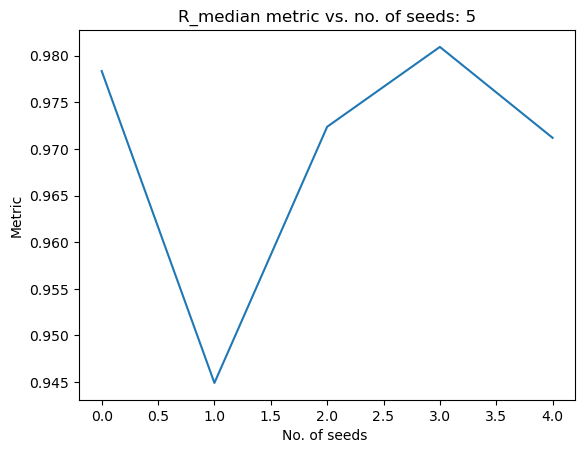

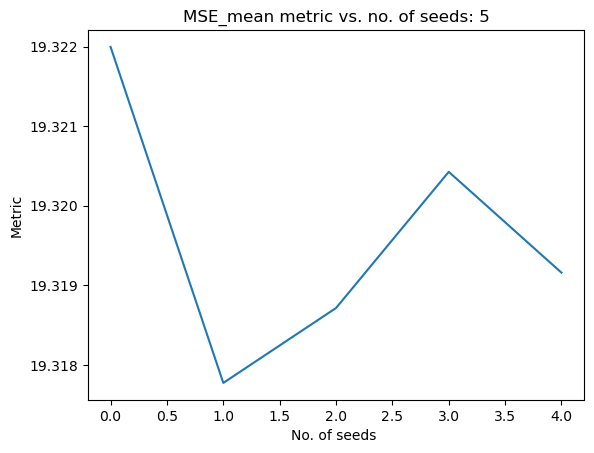

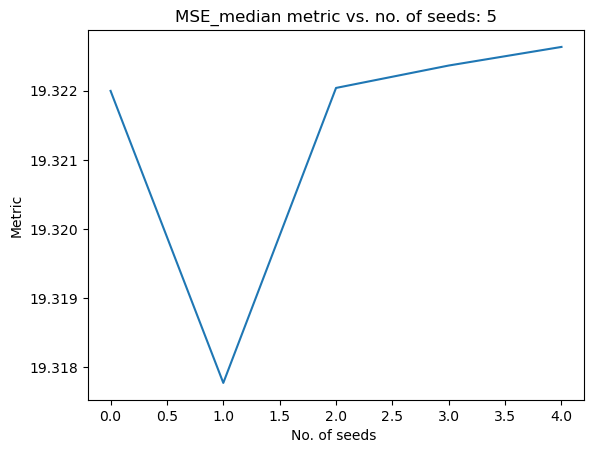

Time required: 48947.01373958588
Best solution found: 
X = [-9.41618676e+00  1.14935801e+00  1.32690210e-01 -4.15645780e+00
  4.85858650e-01  1.24413752e-08  4.59042300e-01 -4.41232510e+00
  2.97552846e-01  4.23245165e+00  3.08649853e+00  3.25710882e+00
  4.33925987e-01  3.60730061e-02  2.97155464e+00  1.75282542e-02
  4.61001524e-01 -1.12898801e+01  1.76761508e+00  1.49058398e+00
 -9.47300928e+00  9.62170996e-01  3.26155888e+00  8.27689713e-02
  3.14985923e+00  2.33954908e+00  9.52059097e-01  5.67782891e+00
 -8.96734036e+00  2.47382355e+00  1.59894116e+00  3.17464178e+00
 -4.35422765e+00  5.52520341e-01  9.86084004e-01 -1.30102998e+00]
F = [19.31922556]
CV = [0.]
R2: 0.8912196465882694
R: 0.9440443032973979
-log10(1-R2): 0.9634495345582154
Mean solution thus far: 
 [-9.47439074484966, 1.1587042972654127, 0.14124801927559963, -4.156514529065518, 0.48587012954562203, 1.2017498971100873e-06, 0.4590818714232483, -4.42213072712986, 0.29883429592192123, 4.2368657634353335, 3.088512467712522

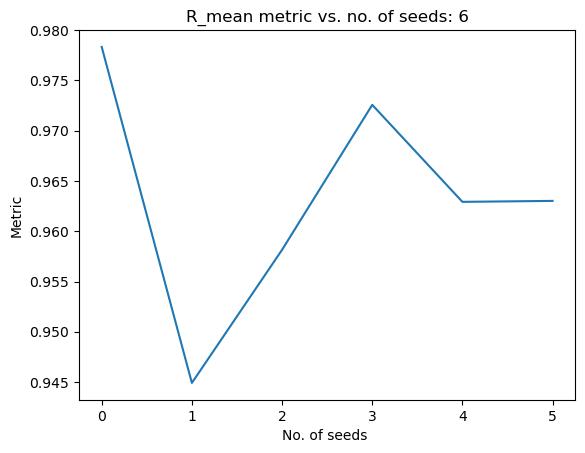

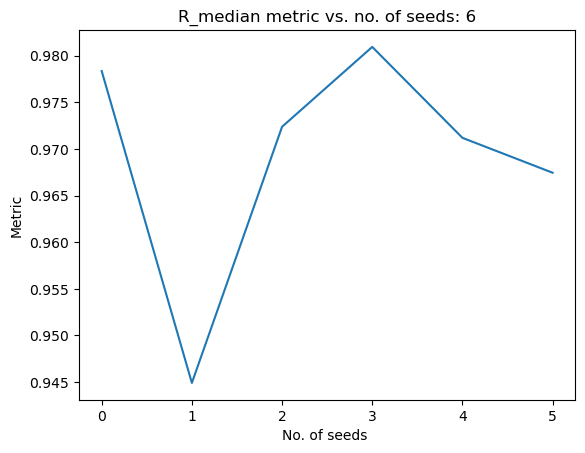

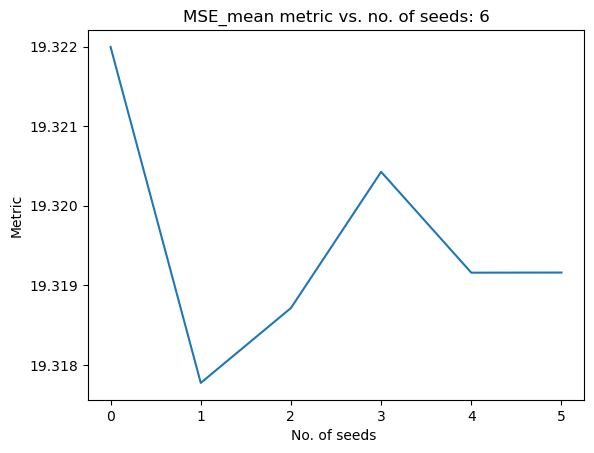

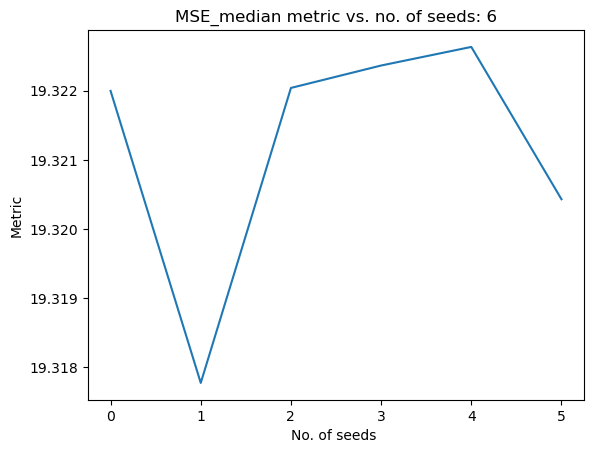

Time required: 48824.08518958092
Best solution found: 
X = [-9.07586766e+00  1.09465848e+00  8.27306567e-02 -4.15917475e+00
  4.86052021e-01  4.87246939e-07  4.59276296e-01 -4.71764705e+00
  3.35244233e-01  4.42197355e+00  3.23206953e+00  3.39418512e+00
  4.51351982e-01  3.65621769e-02  3.00238572e+00  2.03762939e-02
  4.52766490e-01 -1.16168068e+01  1.82533731e+00  1.53772767e+00
 -9.77733599e+00  9.99516611e-01  3.37020681e+00  8.72167421e-02
  3.24879547e+00  2.62069699e+00  1.06408510e+00  6.23688101e+00
 -8.67154145e+00  2.43353439e+00  1.67663695e+00  3.11865276e+00
 -4.54922349e+00  5.89173131e-01  1.01775161e+00 -1.30102983e+00]
F = [19.32938645]
CV = [0.]
R2: 0.9015190019779201
R: 0.9494835448694833
-log10(1-R2): 1.0066475588451615
Mean solution thus far: 
 [-9.417458875230581, 1.1495548949165848, 0.13288839604433647, -4.156894560293828, 0.48589611407675076, 1.0996780460044228e-06, 0.45910964642093416, -4.464347344111057, 0.30403571556183145, 4.263309733488071, 3.1090206189263

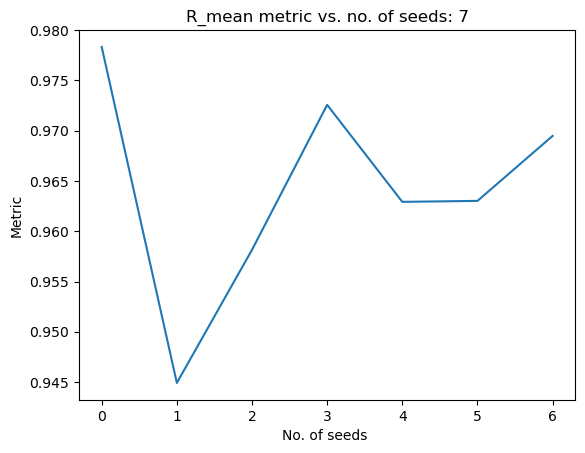

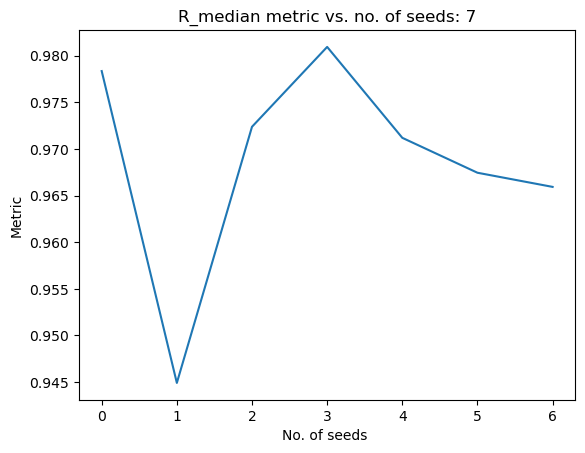

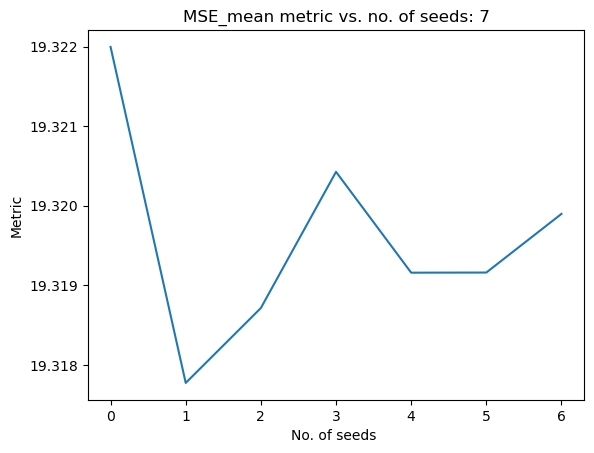

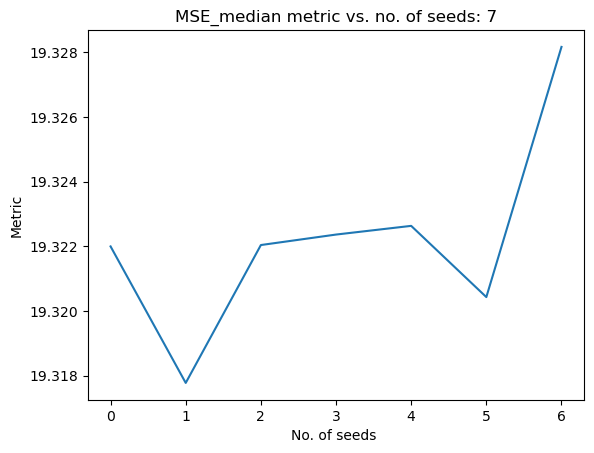

Time required: 48839.22243118286
Best solution found: 
X = [-9.11357124e+00  1.10079649e+00  8.92668863e-02 -4.15255113e+00
  4.85239162e-01  1.34217384e-07  4.58984867e-01 -4.46259157e+00
  3.04281265e-01  4.25638469e+00  3.10376829e+00  3.27329058e+00
  4.23208595e-01  3.58479584e-02  2.96222764e+00  1.85490229e-02
  4.67749799e-01 -1.11505778e+01  1.74292059e+00  1.47276439e+00
 -9.53633051e+00  9.67984564e-01  3.28228129e+00  7.67046845e-02
  3.19346510e+00  2.35400506e+00  9.86392958e-01  5.80859570e+00
 -9.25776538e+00  2.54558251e+00  1.60660903e+00  3.25929041e+00
 -4.35237090e+00  5.52423708e-01  9.88141386e-01 -1.30102997e+00]
F = [19.32135698]
CV = [0.]
R2: 0.8938659408995946
R: 0.9454448375762567
-log10(1-R2): 0.9741452258466485
Mean solution thus far: 
 [-9.379472920380454, 1.1434600946749736, 0.1274357073249487, -4.156351631686807, 0.4858139950864542, 9.78995463212476e-07, 0.4590940489329653, -4.464127872931775, 0.3040664091805597, 4.262444102720092, 3.1083640782243984, 3

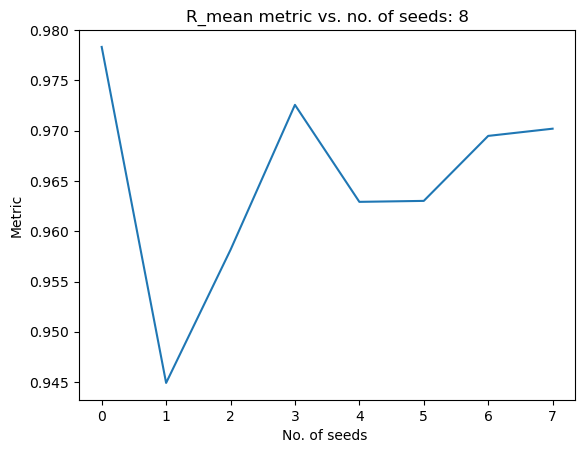

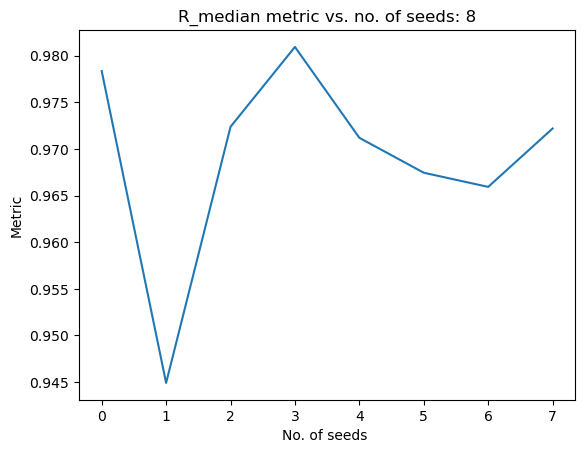

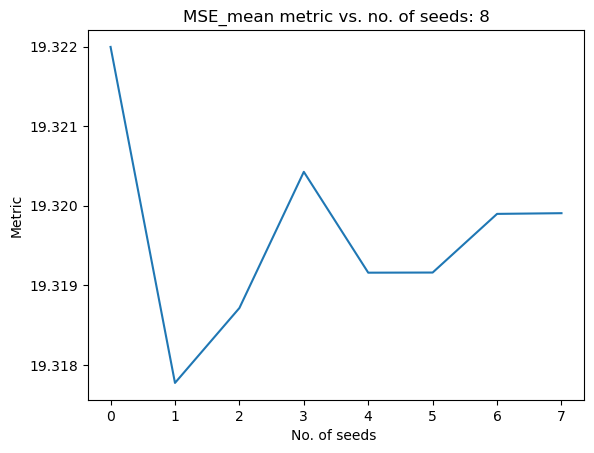

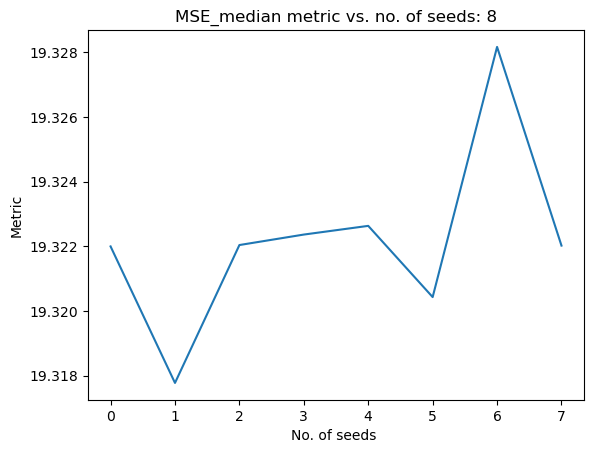

In [ ]:
noSeed=100

import random
from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n') # Opt algorithim in use

# To evaluate MSE
problemInstance = MyProblem()
problemInstance._derivatives_error_fcn_gen(X,y)
OUT = {} # For storing MSE as OUT["F"]

resX_list=[] #1 initiate list to store kr of each seed
MSE_resX_list=[]#2.1 initiate list to store MSE of each seed
R_each_seed_list=[] #2.2 initiate list to store R2 of each seed

averaged_arrays = [] #3 Initialize list to store averaged kr TIL CURRENT SEED
MSE_mean_list=[] # 4.1
R_mean_list=[] #4.2 store R2 of mean kr til current seed

median_arrays=[] #5  Initialize list to cummulatively store median kr TIL CURRENT SEED
MSE_median_list=[] #6.1
R_median_list=[] #6.2 store R2 of mean kr til current seed

for i in range(0,noSeed): # for each seed = 0,1,2,...,noSeed-1
    
    ####1 Calculate kr for current seed
    f_min_history = [] # for storing convergence profile of objective function for current optimization
    def callback(res):
        f_min_history.append(res.opt.get("F").min())
    # The optimization
    res = minimize(problem,
               algorithm,
               termination, 
               callback=callback, parallel=True,                
               seed=i,
               verbose=False)
    resX_list.append(res.X) ####1 store kr for current seed
    MSE_resX_list.append(res.F) ####2.1 store MSE for current seed
    pool.close()
    print('Time required:', res.exec_time)
    print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

    
    ####2.2 Calculate & store R-based metric for CURRENT seed
    resX=np.ndarray.tolist(res.X)
    del resX[-2]
    R2, R, neglog = computeR2(resX,logkr)
    R_each_seed_list.append(neglog) ####2.2
    
    
    ####3 Calculate average kr til current seed
    averages = [] # inititate list of mean kr[i]
    for value_idx in range(len(resX_list[0])): # iter thru index of first available kr: 0,1,2,...,len-1
        # calculate average kr[value_idx]
        avg_value = sum(   array[value_idx] for array in resX_list[: len(resX_list) ]   ) / len(resX_list) # [:10] : 0,1,2...,9
        # add average kr[value_idx] to average kr
        averages.append(avg_value) # store average for kr[value_idx] into 'average kr til current seed'
    averaged_arrays.append(averages) # store average kr till current seed 
    print( "Mean solution thus far: \n %s" % (averages) )
    
    ####4.1 Calculate & store MSE from mean kr
    problemInstance._evaluate(averages,OUT)
    MSE_mean= OUT["F"]
    MSE_mean_list.append(MSE_mean[0]) 
    ####4.2 Calculate & store -log10(1-R2) of mean krs til current seed
    del averages[-2]
    mean_R2, mean_R, mean_neglog = computeR2(averages,logkr)
    R_mean_list.append(mean_neglog)
        
    ####5 Calculate median kr til current seed
    medians = [] # inititate list of median kr[i]
    for value_idx in range(len(resX_list[0])): # iter thru index of first available kr: 0,1,2,...,len-1
        # calculate median kr[value_idx]
        XXX=[]
        for array in resX_list[ : len(resX_list) ]:
            XXX.append( array[value_idx] )
        XX=np.array(XXX)
        median_value = np.median(XX)
        # add median kr[value_idx] to median kr
        medians.append(median_value) # store median kr[value_idx] into 'median kr til current seed'
    median_arrays.append(medians) # store median kr till current seed
    print( "Median solution thus far: \n %s" % (medians) )
    
    ####6.1 Calculate MSE from median kr
    problemInstance._evaluate(medians,OUT)
    MSE_median= OUT["F"]
    MSE_median_list.append(MSE_median[0])
    ####6.2 Calculate & store -log10(1-R2) of median kr til current seed
    del medians[-2]
    median_R2, median_R, median_neglog = computeR2(medians,logkr)
    R_median_list.append(median_neglog)

    
    #Create folders with given name to store cummulative R2 plots
    plot_neglog(R_mean_list,"R_mean")# \mean folder
    plot_neglog(R_median_list,"R_median")# \median folder
    
    plot_neglog(MSE_mean_list,"MSE_mean")# \mean folder
    plot_neglog(MSE_median_list,"MSE_median")# \median folder
    
    
    with open('50noise_G3PCX_MM_neglogR_values_HC5.txt', 'w') as file: # OUTPUT file name
        
        ####2.1 MSE of each seed
        file.write("MSE of each kr solution \n\n")
        for item in MSE_resX_list:
            file.write(str(item[0]) + '\n')
        
        ####2.2 R-based metric of each seed
        file.write("-log(1-R2) metric of each kr solution \n\n")
        for item in R_each_seed_list:
            file.write(str(item) + '\n')

        ####4.1 MSE of mean krs
        file.write("\n MSE metric of mean kr \n\n")
        for item in MSE_mean_list:
            file.write(str(item) + '\n')
        ####4.2 R-based metric of mean krs
        file.write("\n -log(1-R2) metric of mean kr \n\n")
        for item in R_mean_list:
            file.write(str(item) + '\n')
            
        ####6.1 MSE of median krs
        file.write("\n MSE metric median kr \n\n")
        for item in MSE_median_list:
            file.write(str(item) + '\n')
        ####6.2 R-based metric of median kr
        file.write("\n -log(1-R2) metric of median kr \n\n")
        for item in R_median_list:
            file.write(str(item) + '\n')
        
        ####1 kr for each seed
        file.write("\n Kr solution for each Seed \n\n")
        for item in resX_list:
            file.write(str(item) + '\n\n')

# Final median Kr & R2 value

In [ ]:
median_Kr_final = median_arrays[noSeed-1]
del median_Kr_final[-2]
median_Kr_R2, median_Kr_R, median_Kr_neglog=computeR2(median_Kr_final,logkr)

for i in range(len (median_Kr_final)):
    print (median_Kr_final[i])

# Final mean Kr & R2 value

In [ ]:
average_Kr_final = averaged_arrays[noSeed-1]
del average_Kr_final[-2]
average_Kr_R2, average_Kr_R, average_Kr_neglog=computeR2(average_Kr_final,logkr)

for i in range(len (average_Kr_final)):
    print (average_Kr_final[i])

## pre-existing things

In [ ]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3
    
import numpy as np
logkr=np.log10(kr)
logkr

In [ ]:
y_mean = np.mean(logkr)
del median_Kr_final[-2]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

In [ ]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)
logkr=np.ndarray.tolist(logkr)
y_mean = np.mean(logkr)


# average of log kr of 3 seeds
krseed1 = np.ndarray.tolist(res.X)
krseed10 = [ 1.34677445,  8.86459508,  8.72068479,  0.22732033,  7.85253032,
        7.79052595,  7.57409756,  2.28870365,  5.21379597,  8.55752348,
        6.80313645,  8.34938564,  0.05158923,  6.14696743,  5.28246214,
        6.43955587,  6.04312662,  0.69587499,  6.70823182,  1.68624638,
        8.66839026,  8.67534794,  8.71450485,  7.70616042,  0.32295689,
        6.33111515,  3.68889542,  6.74533321,  8.75261333,  8.6639745 ,
        1.10099455,  8.11054405, -1.30103   ,  0.67166518]
krseed101 = [ 1.40208756,  8.88655455,  9.        ,  0.98327069,  8.20437647,
        8.1250088 ,  7.98346734,  0.43319408,  4.5563004 ,  6.36989142,
        7.16580366,  6.49188593,  1.09328354,  7.24392182,  6.41222964,
        7.43638798,  7.08185726,  1.16658744,  7.18173278,  0.7812721 ,
        7.47752308,  7.71475652,  7.9070189 ,  6.82344891,  0.89933335,
        6.90576415,  1.49347143,  4.59783142,  6.66141546,  6.40750649,
        1.80743151,  8.81286993, -1.30103   ,  0.25513891]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()

# Getting all the array values from the output text file into a list again

In [ ]:
#first copy out only the solutions from the output text file into a new file.

import numpy as np

# Read the data from the file
with open('50noise_G3PCX_MM_neglogR_SolutionsOnly.txt', 'r') as file: #rename this to the NEW FILE WITH ONLY SOLUTIONS
    data = file.read()

# Split the data into individual arrays based on empty lines
blocks = data.strip().split('\n\n')

# Clean and convert each block into a NumPy array
arrays = []
for block in blocks:
    # Remove '[' and ']' characters and split by whitespace to get numeric values
    numeric_values = block.replace('[', '').replace(']', '').split()
    # Convert the list of strings to a NumPy array of floats
    array = np.array(list(map(float, numeric_values)))
    arrays.append(array)
    
krs= arrays
#Now arrays has the list of solutions for all the seeds from the loop, can be visualised/studied further

# calculate R2 of mean Kr

In [ ]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)
logkr=np.ndarray.tolist(logkr)
y_mean = np.mean(logkr)

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-2]

# R2 of fitting actual logkr =  modeled logkr
RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

# Calculate R2 of median Kr

In [ ]:
# Use stored solution
kr = [1e+01, 10**8.5,10**8.5, # AtoB
      1e+02, 10**9, 10**9, 10**9, # HMGS
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # HMGR
      1e+02, 1e+08, 1e+08, 1e+08, 1e+08, # MK        
      1e+02, 1e+08, # PMK
      1e+01, 1e+08, 1e+08, 1e+08, 1e+07, # PMD
      1e+01, 1e+07, # IDI 
      1e+03, 1e+06, 1e+08, 1e+08, # GPPS
      1e+01, 1e+08, # LS
      10**0.1] # Vin set to 0.05, ks3

import numpy as np
logkr=np.log10(kr)
logkr=np.ndarray.tolist(logkr)
y_mean = np.mean(logkr)

mediankr=np.median(krs, axis=0)

mediankr=np.ndarray.tolist(mediankr)
del mediankr[-2]

# R2 of fitting actual logkr =  modeled logkr
RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,mediankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (mediankr)):
    print (mediankr[i])